<a href="https://colab.research.google.com/github/YuanzheHu/AMLS_II_24_25_SN21024516/blob/main/resnet152_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Modules

In [ ]:
import pandas as pd
import numpy as np
import time
import os
import copy
import json

# visualization modules
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms

# augmentation
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive

# 挂载 Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the Dataset

In [ ]:
BASE_DIR = "/content/drive/MyDrive/AMLS-II/Coursework/cassava-leaf-disease-classification/"
train = pd.read_csv(BASE_DIR+'train.csv')
train.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [ ]:
# loading mapping for target label
with open(BASE_DIR+'label_num_to_disease_map.json') as f:
    mapping = json.loads(f.read())
    mapping = {int(k): v for k, v in mapping.items()}
mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [ ]:
train['label_names'] = train['label'].map(mapping)
train.head()

image_id  label                          label_names
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)

## Exploratory Data Analysis

In [ ]:
def plot_images(class_id, label, total_images=6):
    # get image ids corresponding to the target class id
    plot_list = train[train['label']==class_id].sample(total_images)['image_id'].tolist()

    labels = [label for i in range(total_images)]
    # dynamically set size for subplot
    size = int(np.sqrt(total_images))
    if size*size < total_images:
        size += 1

    # set figure size
    plt.figure(figsize=(15,15))

    # plot the image in subplot
    for index, (image_id, label) in enumerate(zip(plot_list, labels)):
        plt.subplot(size, size, index+1)
        image = Image.open(str(BASE_DIR+'train_images/'+image_id))
        plt.imshow(image)
        plt.title(label, fontsize=14)
        plt.axis('off')

    plt.show()

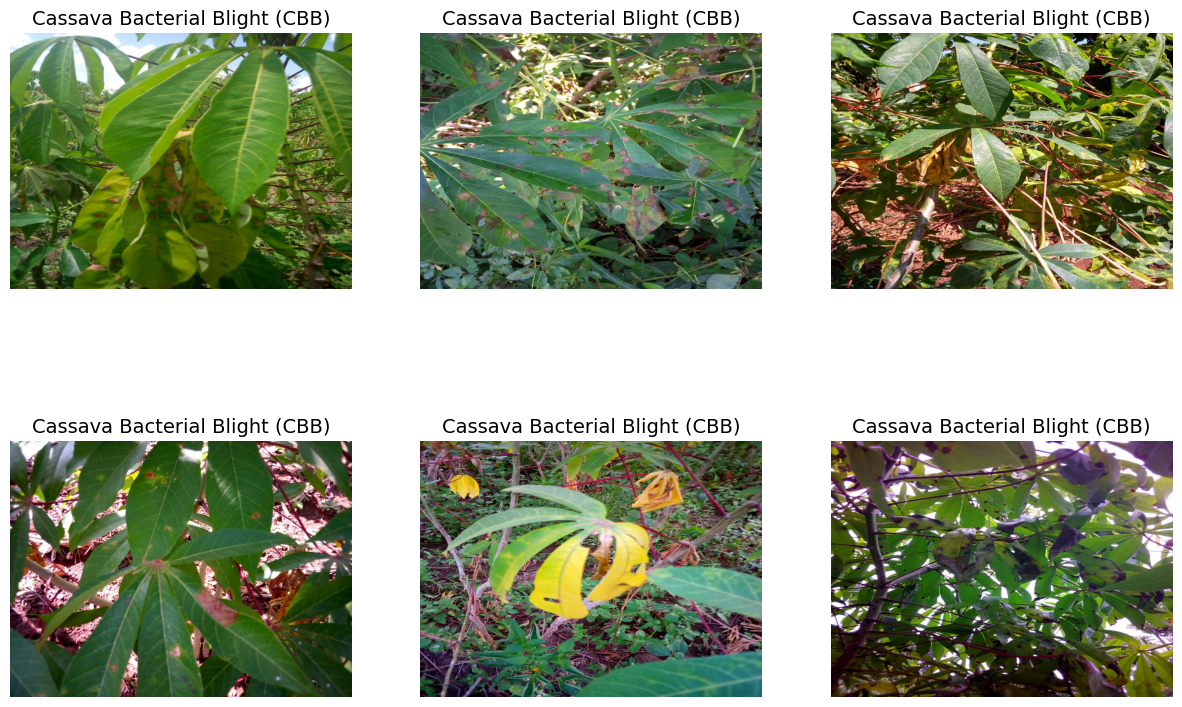

In [ ]:
plot_images(0, mapping[0], 6)

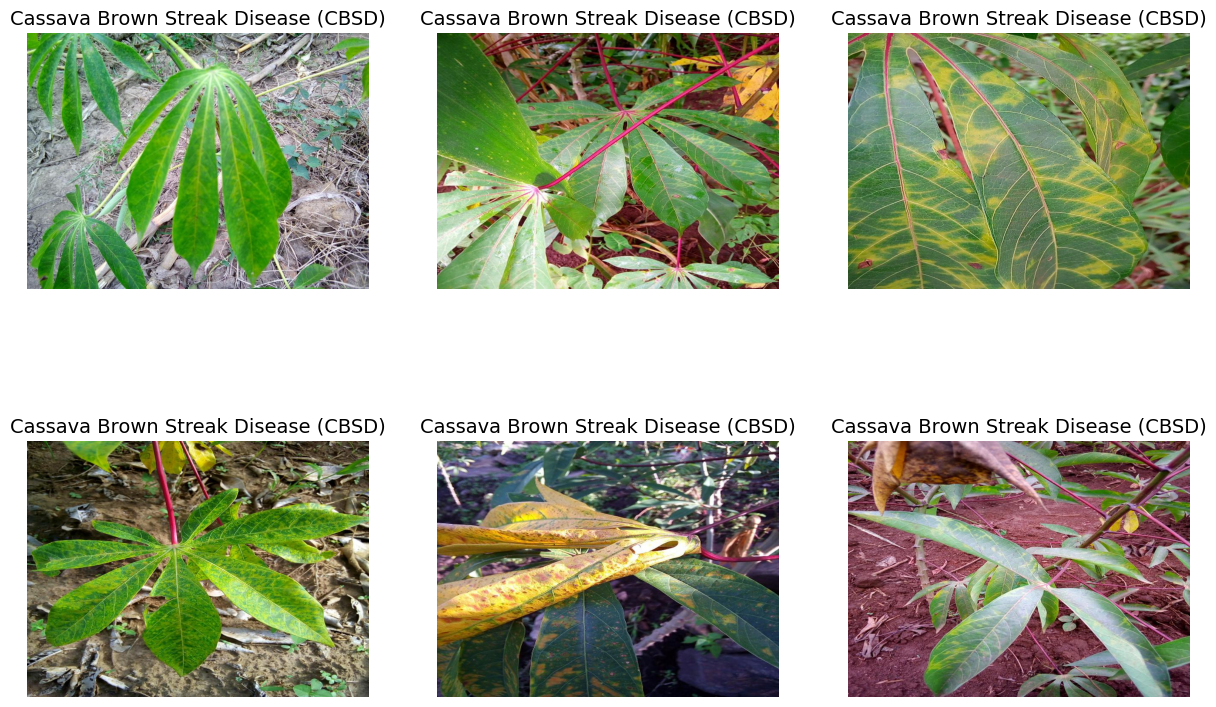

In [ ]:
plot_images(1, mapping[1], 6)

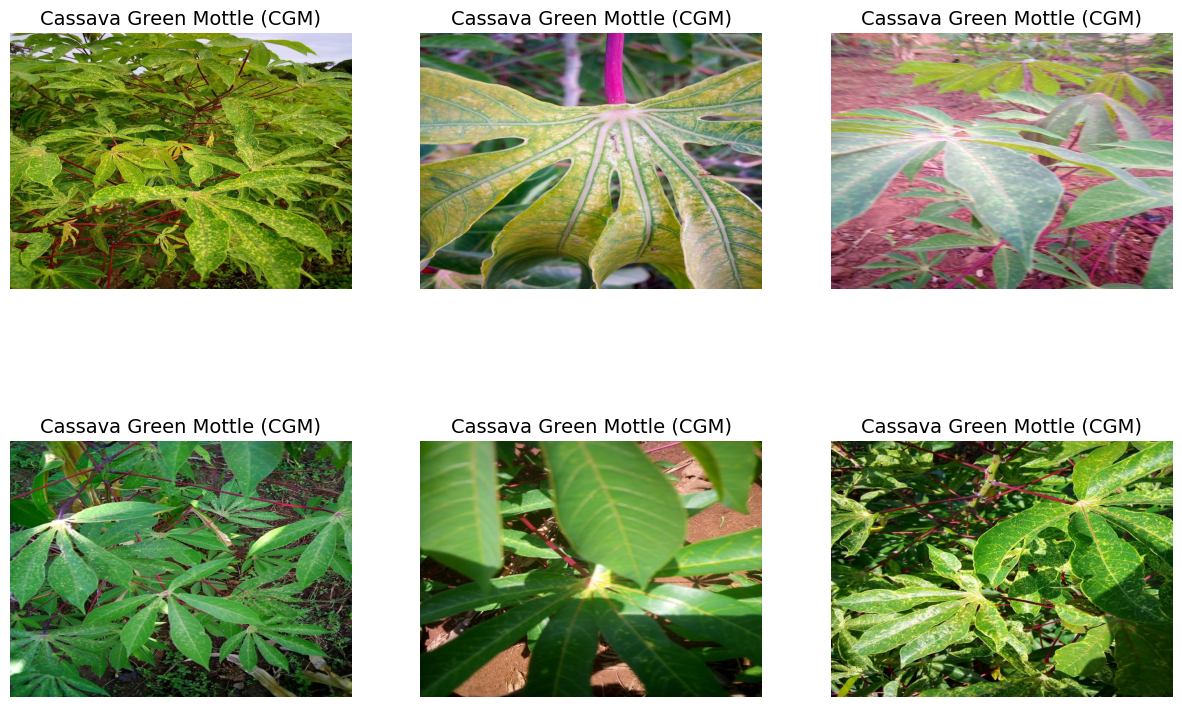

In [ ]:
plot_images(2, mapping[2], 6)

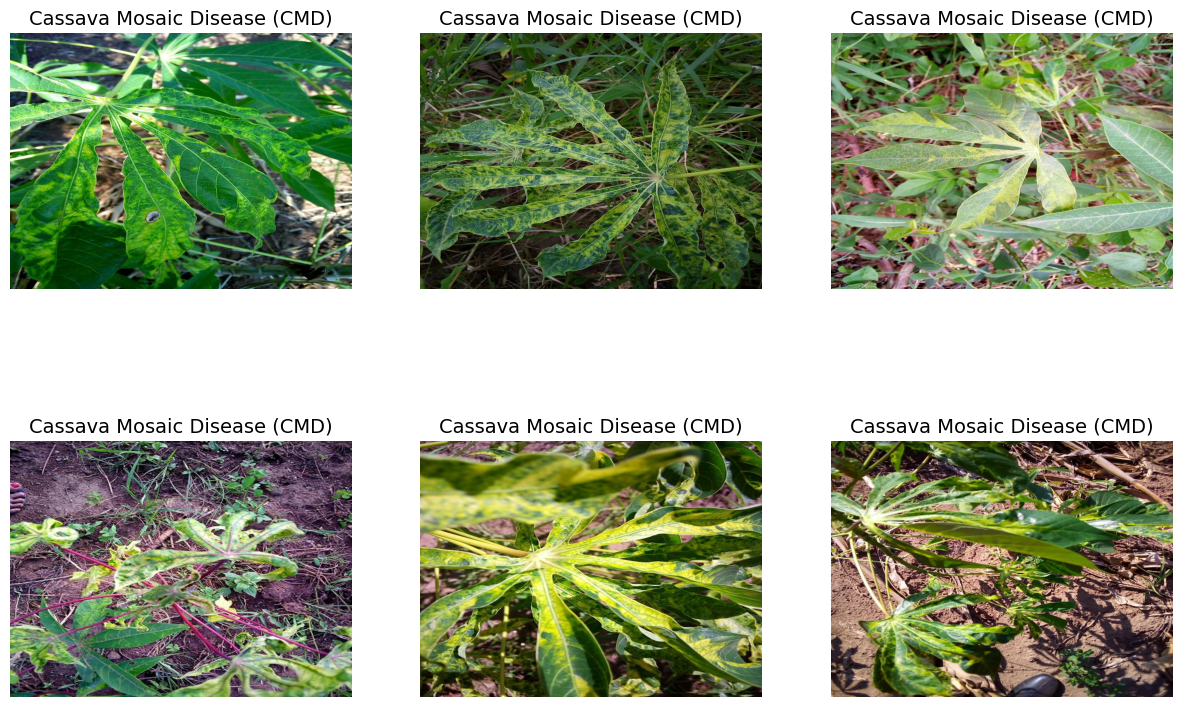

In [ ]:
plot_images(3, mapping[3], 6)

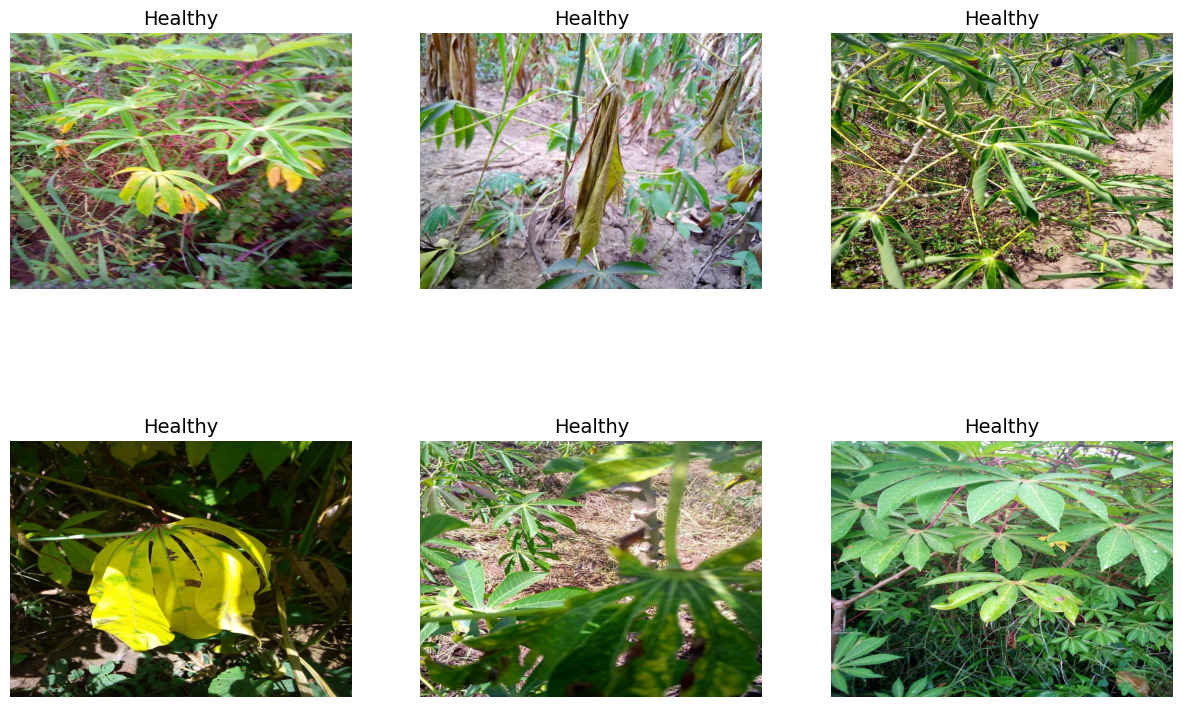

In [ ]:
plot_images(4, mapping[4], 6)

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.]),
 [Text(0.0, 0, '0'),
  Text(2000.0, 0, '2000'),
  Text(4000.0, 0, '4000'),
  Text(6000.0, 0, '6000'),
  Text(8000.0, 0, '8000'),
  Text(10000.0, 0, '10000'),
  Text(12000.0, 0, '12000'),
  Text(14000.0, 0, '14000')])

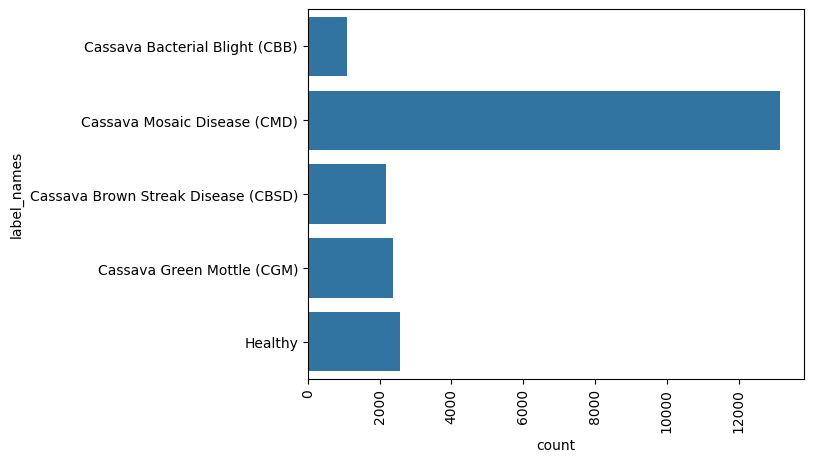

In [ ]:
# class distribution
sns.countplot(train['label_names'])
plt.xticks(rotation=90)

In [ ]:
print(train['label_names'].value_counts().sort_index())

label_names
Cassava Bacterial Blight (CBB)          1087
Cassava Brown Streak Disease (CBSD)     2189
Cassava Green Mottle (CGM)              2386
Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Name: count, dtype: int64


## Configuration and Utility Functions

In [ ]:
DIM = (256, 256)
WIDTH, HEIGHT = DIM
NUM_CLASSES = 5
NUM_WORKERS = 24
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
SEED = 1

DEVICE = 'cuda'

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

## Augmentations

In [ ]:
def get_test_transforms(value = 'val'):
    if value == 'train':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.Rotate(limit=(-90, 90)),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
            ToTensorV2(p=1.0)
        ])
    elif value == 'val':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),
            albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
            ToTensorV2(p=1.0)
        ])

## Dataset Loader Class

In [ ]:
class CassavaDataset(Dataset):
    def __init__(self, image_ids, labels, dimension=None, augmentations=None, folder='train_images'):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.dim = dimension
        self.augmentations = augmentations
        self.folder = folder

    # returns the length
    def __len__(self):
        return len(self.image_ids)

    # return the image and label for that index
    def __getitem__(self, idx):
        img = Image.open(os.path.join(BASE_DIR, self.folder, self.image_ids[idx]))

        if self.dim:
            img = img.resize(self.dim)

        # convert to numpy array
        img = np.array(img)

        if self.augmentations:
            augmented = self.augmentations(image=img)
            img = augmented['image']

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train['image_id'], train['label'], test_size=0.25)

In [ ]:
from torch.utils.data import WeightedRandomSampler
def sampler_(labels):
    label_unique, counts = np.unique(labels, return_counts=True)
    print('Unique Labels', label_unique)
    weights = [sum(counts) / c for c in counts]
    sample_weights = [weights[w] for w in labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

In [ ]:
train_sampler = sampler_(y_train)

Unique Labels [0 1 2 3 4]


In [ ]:
# create dataloaders for training antrain_test_splitidation
train_dataset = CassavaDataset(
    image_ids=x_train.values,
    labels=y_train.values,
    augmentations=get_test_transforms('train'),
    dimension=DIM
)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    sampler=train_sampler
)

val_dataset = CassavaDataset(
    image_ids=x_test.values,
    labels=y_test.values,
    augmentations=get_test_transforms('val'),
    dimension=DIM
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

loaders = {'train': train_loader, 'val': val_loader}

In [ ]:
# to check whether dataset is working or not
# fetch the data based on index
val_dataset[0]

(tensor([[[ 0.0912,  0.0227, -0.2171,  ..., -1.3130, -0.7822, -0.3883],
          [ 0.0227,  0.0227,  0.0056,  ..., -1.0219, -0.8849, -0.8335],
          [-0.1143, -0.0801,  0.0056,  ..., -0.7308, -0.8335, -0.5767],
          ...,
          [-0.5767, -0.5253, -0.5596,  ..., -1.6555, -1.7240, -1.7754],
          [-0.5767, -0.5424, -0.5767,  ..., -1.6898, -1.7240, -1.7925],
          [-0.5767, -0.5938, -0.6965,  ..., -1.7069, -1.7583, -1.8268]],
 
         [[ 0.2227,  0.1877, -0.0049,  ..., -0.8102, -0.3725, -0.1450],
          [ 0.1877,  0.2227,  0.2402,  ..., -0.7402, -0.6001, -0.5826],
          [ 0.1001,  0.1527,  0.2577,  ..., -0.6877, -0.7052, -0.3025],
          ...,
          [ 0.3452,  0.3627,  0.2752,  ..., -1.0553, -1.0903, -1.1078],
          [ 0.2927,  0.3277,  0.2927,  ..., -1.0728, -1.0903, -1.1253],
          [ 0.2577,  0.2752,  0.2227,  ..., -1.1078, -1.1253, -1.1604]],
 
         [[-0.4624, -0.5147, -0.6193,  ..., -1.7347, -1.4559, -1.3339],
          [-0.3753, -0.3578,

## Use Pretrained Model (Transfer Learning)

In [ ]:
def getModel():
    net = models.resnet152(pretrained=True)

    # if you want to train the whole network, comment this code
    # freeze all the layers in the network
    for param in net.parameters():
        param.requires_grad = False

    num_ftrs = net.fc.in_features
    # create last few layers
    net.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, NUM_CLASSES),
        nn.LogSoftmax(dim=1)
    )

    # use gpu if any
    net = net.cuda() if DEVICE else net
    return net

In [ ]:
model = getModel()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 178MB/s]


In [ ]:
import math
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=1., momentum=0.9)
step_size = 4*len(train_loader)
clr = cyclical_lr(step_size, min_lr=3e-4, max_lr=3e-3)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

In [ ]:
# print(model)

In [ ]:
# freeze (or) unfreeze all the layers
unfreeze = True # to freeze, set it as False
for param in model.parameters():
    param.requires_grad = unfreeze

In [ ]:
# find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters')
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{trainable_params:,} training parameters')

58,669,637 total parameters
58,669,637 training parameters


## Steps for Training and Validation

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5, scheduler=scheduler):
    # set starting time
    start_time = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*15)

        # each epoch have training and validation phase
        for phase in ['train', 'val']:
            # set mode for model
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            fin_out = []

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                # move data to corresponding hardware
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # reset (or) zero the parameter gradients
                optimizer.zero_grad()

                # training (or) validation process
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # back propagation in the network
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # calculate loss and accuarcy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # print loss and acc for training & validation
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # update the best weights
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
    end_time = time.time() - start_time

    print('Training completes in {:.0f}m {:.0f}s'.format(end_time // 60, end_time % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# train the model
model, accuracy = train_model(model=model, dataloaders=loaders, criterion=criterion, optimizer=optimizer, num_epochs=5, scheduler=scheduler)

Epoch 0/4
---------------
train Loss: 1.2361 Acc: 0.5043
val Loss: 0.6139 Acc: 0.7834

Epoch 1/4
---------------
train Loss: 0.7223 Acc: 0.7332
val Loss: 0.6123 Acc: 0.7746

Epoch 2/4
---------------
train Loss: 0.6071 Acc: 0.7840
val Loss: 0.4816 Acc: 0.8357

Epoch 3/4
---------------
train Loss: 0.5567 Acc: 0.8017
val Loss: 0.6448 Acc: 0.7936

Epoch 4/4
---------------
train Loss: 0.4995 Acc: 0.8193
val Loss: 0.5283 Acc: 0.8301

Training completes in 44m 48s
Best Val Acc: 0.8357


In [1]:
from google.colab import drive
import torch

# 挂载 Google Drive
drive.mount('/content/drive')

# 指定 Google Drive 的保存路径
drive_path = "/content/drive/MyDrive/best_model.h5"
weights_drive_path = "/content/drive/MyDrive/best_model_weights.pth"

torch.save(model, drive_path)
torch.save(model.state_dict(), weights_drive_path)

print(f"Model saved at {drive_path}")
print(f"Weights saved at {weights_drive_path}")

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# freeze (or) unfreeze all the layers
unfreeze = True # to freeze, set it as False
for param in model.parameters():
    param.requires_grad = unfreeze

In [ ]:
# # unfreeze seleected layers
# layers = list(range(5,7))
# i = 0
# for layer in model.children():
#     if i in layers:
#         for param in layer.parameters():
#             param.requires_grad = True
#     i += 1

In [ ]:
# find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters')
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{trainable_params:,} training parameters')

58,669,637 total parameters
58,669,637 training parameters


In [ ]:
# # gives the number of layers
# for i,layer in enumerate(model.children()):
#     print(i)

## Testing the Model

In [ ]:
# empty the cache from cuda device
torch.cuda.empty_cache()

In [ ]:
# 挂载 Google Drive
drive.mount('/content/drive')

# 设置设备
DEVICE = torch.cuda.is_available()
NUM_CLASSES = 5
model_path = "/content/drive/MyDrive/best_model.h5"

# 加入 ResNet152 到可信列表（解决安全限制）
torch.serialization.add_safe_globals([models.resnet152])

# 加载模型（包含结构 + 权重）
model = torch.load(model_path, weights_only=False)
model = model.cuda() if DEVICE else model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np

def predict(model, dataloader, device):
    model.eval()
    fin_out = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Predicting", leave=True):
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            fin_out.append(F.softmax(outputs, dim=1).detach().cpu().numpy())

    return np.concatenate(fin_out)

In [ ]:
# steps for model prediction
device = torch.device('cuda') # if you don't have gpu, set it as cpu
model.to(device)
pred = predict(model, val_loader, device)
pred = pred.argmax(axis=1)

Predicting: 100%|██████████| 168/168 [01:17<00:00,  2.16it/s]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def evaluate(model, dataloader, device, class_names=None, show_confusion_matrix=False):
    """
    Evaluate a PyTorch classification model on a dataloader.

    Args:
        model (torch.nn.Module): Trained model
        dataloader (DataLoader): Validation or test dataloader
        device (torch.device): torch.device('cuda') or torch.device('cpu')
        class_names (list[str], optional): For prettier classification report
        show_confusion_matrix (bool): Whether to print confusion matrix

    Returns:
        dict: A dictionary containing accuracy, classification report, and optionally confusion matrix
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cls_report = classification_report(all_labels, all_preds, target_names=class_names)

    print(f"\nAccuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(cls_report)

    results = {
        "accuracy": acc,
        "classification_report": cls_report
    }

    if show_confusion_matrix:
        cm = confusion_matrix(all_labels, all_preds)
        print("Confusion Matrix:")
        print(cm)
        results["confusion_matrix"] = cm

    return results

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = [
    "Cassava Bacterial Blight (CBB)",
    "Cassava Mosaic Disease (CMD)",
    "Cassava Brown Streak Disease (CBSD)",
    "Cassava Green Mottle (CGM)",
    "Healthy"
]

evaluate(model, val_loader, device, class_names=class_names, show_confusion_matrix=True)

Evaluating: 100%|██████████| 168/168 [01:21<00:00,  2.05it/s]


Accuracy: 0.8725

Classification Report:
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.69      0.79      0.74       285
       Cassava Mosaic Disease (CMD)       0.79      0.79      0.79       553
Cassava Brown Streak Disease (CBSD)       0.81      0.67      0.73       565
         Cassava Green Mottle (CGM)       0.95      0.95      0.95      3290
                            Healthy       0.69      0.77      0.73       657

                           accuracy                           0.87      5350
                          macro avg       0.79      0.79      0.79      5350
                       weighted avg       0.88      0.87      0.87      5350

Confusion Matrix:
[[ 226   13    3   10   33]
 [  33  438    6   18   58]
 [  11   20  376   85   73]
 [  10   39   60 3121   60]
 [  49   42   21   38  507]]


{'accuracy': 0.8725233644859813,
 'classification_report': '                                     precision    recall  f1-score   support\n\n     Cassava Bacterial Blight (CBB)       0.69      0.79      0.74       285\n       Cassava Mosaic Disease (CMD)       0.79      0.79      0.79       553\nCassava Brown Streak Disease (CBSD)       0.81      0.67      0.73       565\n         Cassava Green Mottle (CGM)       0.95      0.95      0.95      3290\n                            Healthy       0.69      0.77      0.73       657\n\n                           accuracy                           0.87      5350\n                          macro avg       0.79      0.79      0.79      5350\n                       weighted avg       0.88      0.87      0.87      5350\n',
 'confusion_matrix': array([[ 226,   13,    3,   10,   33],
        [  33,  438,    6,   18,   58],
        [  11,   20,  376,   85,   73],
        [  10,   39,   60, 3121,   60],
        [  49,   42,   21,   38,  507]])}

In [ ]:
y_test.values[:5]

array([4, 4, 2, 3, 4])

In [ ]:
pred[:5]

array([4, 4, 2, 3, 0])